In [8]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version
# Check python
!which python

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/home/kites/miniconda3/envs/env/bin/python


In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [11]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!pip install mmdet

!pip install mmrotate

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html


In [12]:
from mmcv import collect_env
collect_env()

{'sys.platform': 'linux',
 'Python': '3.7.11 (default, Jul 27 2021, 14:32:16) [GCC 7.5.0]',
 'CUDA available': True,
 'GPU 0': 'NVIDIA GeForce GTX 1660 Ti',
 'CUDA_HOME': '/usr/local/cuda-11.1',
 'NVCC': 'Build cuda_11.1.TC455_06.29190527_0',
 'GCC': 'gcc (Ubuntu 9.4.0-1ubuntu1~20.04) 9.4.0',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=

In [82]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMRotate installation
import mmrotate
print(mmrotate.__version__)

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
0.1.1
2.22.0
11.1
GCC 7.3


In [114]:
import copy
import os
import time
import matplotlib.pyplot as plt


import torch
import mmcv
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDistributedDataParallel
from mmcv.runner import init_dist, load_checkpoint, wrap_fp16_model
from mmdet.datasets import build_dataloader, replace_ImageToTensor

from mmrotate.datasets import build_dataset
from mmrotate.models import build_detector

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

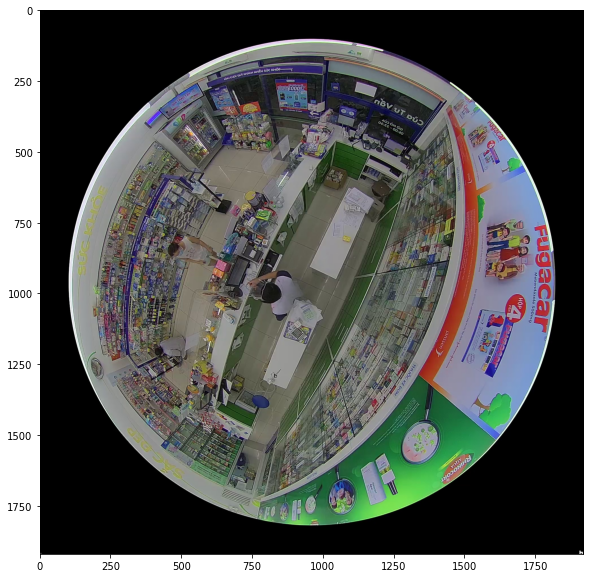

In [15]:
# Let's take a look at the dataset image
img = mmcv.imread('../../../data/PhamacityDota/images/linhdam2_10.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [112]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmrotate/v0.1.0/rotated_retinanet/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth \
      -O checkpoints/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-03-20 18:51:54--  https://download.openmmlab.com/mmrotate/v0.1.0/rotated_retinanet/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.18
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146852804 (140M) [application/octet-stream]
Saving to: ‘checkpoints/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth’

checkpoints/rotated 100%[===================>] 140.05M  6.09MB/s    in 24s     

2022-03-20 18:52:18 (5.86 MB/s) - ‘checkpoints/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth’ saved [146852804/146852804]



In [113]:
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset


@ROTATED_DATASETS.register_module()
class PharmacityDataset(DOTADataset):
    CLASSES = ('person',)

KeyError: 'PharmacityDataset is already registered in dataset'

In [119]:
from mmcv import Config
cfg = Config.fromfile('../configs/rotated_retinanet/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90.py')

In [120]:
!pwd

/home/kites/git/mmrotate/demo


In [121]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'PharmacityDataset'
cfg.data_root = '../../../data/PhamacityDota'

cfg.data.test.type = 'PharmacityDataset'
cfg.data.test.data_root = '../../../data/PhamacityDota'
cfg.data.test.ann_file = 'test'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'PharmacityDataset'
cfg.data.train.data_root = '../../../data/PhamacityDota'
cfg.data.train.ann_file = 'train'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'PharmacityDataset'
cfg.data.val.data_root = '../../../data/PhamacityDota'
cfg.data.val.ann_file = 'val'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
# cfg.model.roi_head.bbox_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth'
# cfg.load_from = './tutorial_exps/epoch_3.pth.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.001
cfg.lr_config.warmup = None
# cfg.runner.max_epochs = 3
cfg.log_config.interval = 100

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 3

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'PharmacityDataset'
data_root = '../../../data/PhamacityDota'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RResize', img_scale=(1024, 1024)),
    dict(
        type='RRandomFlip',
        flip_ratio=[0.25, 0.25, 0.25],
        direction=['horizontal', 'vertical', 'diagonal'],
        version='le90'),
    dict(
        type='PolyRandomRotate',
        rotate_ratio=0.5,
        angles_range=180,
        auto_bound=False,
        rect_classes=[9, 11],
        version='le90'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFrom

In [124]:
import os.path as osp

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-03-20 18:56:05,091 - mmdet - INFO - load checkpoint from local path: checkpoints/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth
2022-03-20 18:56:05,216 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([135, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([9, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([135]) from checkpoint, the shape in current model is torch.Size([9]).
2022-03-20 18:56:05,217 - mmdet - INFO - Start running, host: kites@kites-PC, work_dir: /home/kites/git/mmrotate/demo/tutorial_exps
2022-03-20 18:56:05,219 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook        

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 592/592, 5.1 task/s, elapsed: 116s, ETA:     0s

2022-03-20 20:37:58,477 - mmdet - INFO - 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 592 | 3022 | 0.941  | 0.429 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.429 |
+--------+-----+------+--------+-------+
2022-03-20 20:37:58,479 - mmdet - INFO - Epoch(val) [3][592]	mAP: 0.4292
2022-03-20 20:39:24,573 - mmdet - INFO - Epoch [4][100/2352]	lr: 1.000e-03, eta: 4:51:25, time: 0.861, data_time: 0.028, memory: 3759, loss_cls: 0.2534, loss_bbox: 0.4847, loss: 0.7381, grad_norm: 5.1647
2022-03-20 20:40:48,726 - mmdet - INFO - Epoch [4][200/2352]	lr: 1.000e-03, eta: 4:50:05, time: 0.842, data_time: 0.006, memory: 3759, loss_cls: 0.2618, loss_bbox: 0.5268, loss: 0.7886, grad_norm: 5.8435
2022-03-20 20:42:12,780 - mmdet - INFO - Epoch [4][300/2352]	lr: 1.000e-03, eta: 4:48:45, time: 0.841, data_time: 0.005, memory: 3759, loss_cls: 0.2698, loss_bbox: 0.5006, loss: 0.7704, grad

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 592/592, 5.0 task/s, elapsed: 119s, ETA:     0s

2022-03-20 22:22:59,900 - mmdet - INFO - 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 592 | 2694 | 0.932  | 0.459 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.459 |
+--------+-----+------+--------+-------+
2022-03-20 22:22:59,901 - mmdet - INFO - Epoch(val) [6][592]	mAP: 0.4595
2022-03-20 22:24:27,910 - mmdet - INFO - Epoch [7][100/2352]	lr: 1.000e-03, eta: 3:16:45, time: 0.880, data_time: 0.028, memory: 3759, loss_cls: 0.2395, loss_bbox: 0.5295, loss: 0.7689, grad_norm: 4.9096
2022-03-20 22:25:54,147 - mmdet - INFO - Epoch [7][200/2352]	lr: 1.000e-03, eta: 3:15:23, time: 0.862, data_time: 0.006, memory: 3759, loss_cls: 0.2486, loss_bbox: 0.5137, loss: 0.7623, grad_norm: 5.3764
2022-03-20 22:27:20,223 - mmdet - INFO - Epoch [7][300/2352]	lr: 1.000e-03, eta: 3:14:00, time: 0.861, data_time: 0.006, memory: 3759, loss_cls: 0.2601, loss_bbox: 0.4642, loss: 0.7243, grad

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 592/592, 4.8 task/s, elapsed: 123s, ETA:     0s

2022-03-21 00:09:01,267 - mmdet - INFO - 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 592 | 2791 | 0.954  | 0.509 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.509 |
+--------+-----+------+--------+-------+
2022-03-21 00:09:01,268 - mmdet - INFO - Epoch(val) [9][592]	mAP: 0.5091
2022-03-21 00:10:30,323 - mmdet - INFO - Epoch [10][100/2352]	lr: 1.000e-04, eta: 1:38:27, time: 0.890, data_time: 0.029, memory: 3759, loss_cls: 0.2244, loss_bbox: 0.4315, loss: 0.6559, grad_norm: 5.2961
2022-03-21 00:11:57,923 - mmdet - INFO - Epoch [10][200/2352]	lr: 1.000e-04, eta: 1:37:03, time: 0.876, data_time: 0.006, memory: 3759, loss_cls: 0.2239, loss_bbox: 0.4546, loss: 0.6785, grad_norm: 6.0702
2022-03-21 00:13:25,115 - mmdet - INFO - Epoch [10][300/2352]	lr: 1.000e-04, eta: 1:35:39, time: 0.872, data_time: 0.006, memory: 3759, loss_cls: 0.2265, loss_bbox: 0.4566, loss: 0.6831, g

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 592/592, 5.1 task/s, elapsed: 116s, ETA:     0s

2022-03-21 01:50:53,356 - mmdet - INFO - 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 592 | 2638 | 0.954  | 0.519 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.519 |
+--------+-----+------+--------+-------+
2022-03-21 01:50:53,357 - mmdet - INFO - Epoch(val) [12][592]	mAP: 0.5194


In [ ]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./tutorial_exps

265.6676025390625


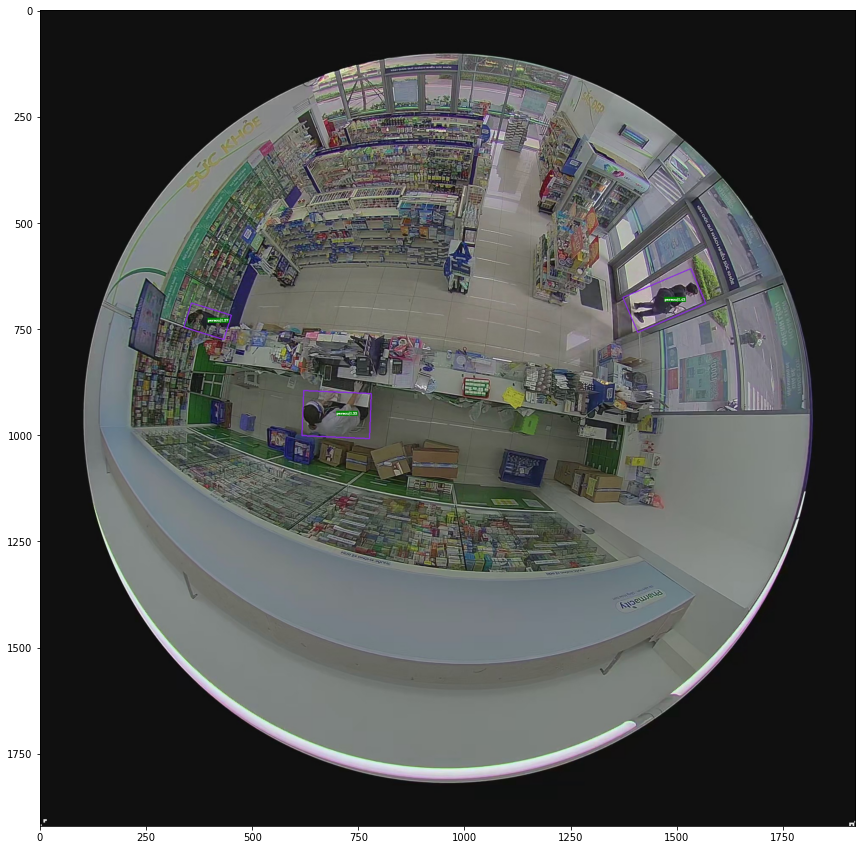

In [136]:
img = mmcv.imread('../../../data/PhamacityDota/images/timecity2_7920.png')
model.cfg = cfg



start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

result = inference_detector(model, img)

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end))


model.show_result(img, result, score_thr=0.3, out_file='./output.png')
img = mmcv.imread('./output.png')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

270.7265319824219


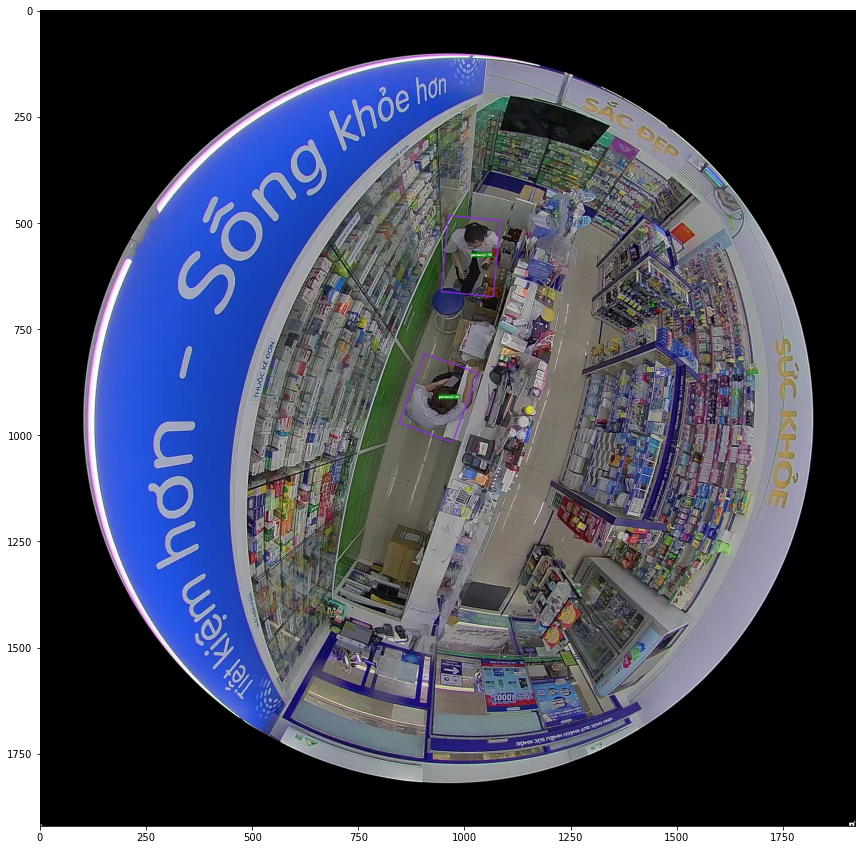

In [137]:
img = mmcv.imread('../../../data/PhamacityDota/images/lyquocsu_quay_000000.png')
model.cfg = cfg



start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

result = inference_detector(model, img)

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end))


model.show_result(img, result, score_thr=0.3, out_file='./output.png')
img = mmcv.imread('./output.png')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [2]:
!python ../tools/analysis_tools/benchmark.py \
  ../configs/roi_trans/roi_trans_r50_fpn_1x_dota_ms_rr_le90.py \
  weights/latest.pth 
        

Traceback (most recent call last):
  File "../tools/analysis_tools/benchmark.py", line 219, in <module>
    main()
  File "../tools/analysis_tools/benchmark.py", line 209, in main
    raise NotImplementedError('Only supports distributed mode')
NotImplementedError: Only supports distributed mode


In [47]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = '../configs/roi_trans/roi_trans_r50_fpn_1x_dota_ms_rr_le90.py'
# Setup a checkpoint file to load
checkpoint = 'weights/latest.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: weights/latest.pth


RoITransformer(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

244.76681518554688


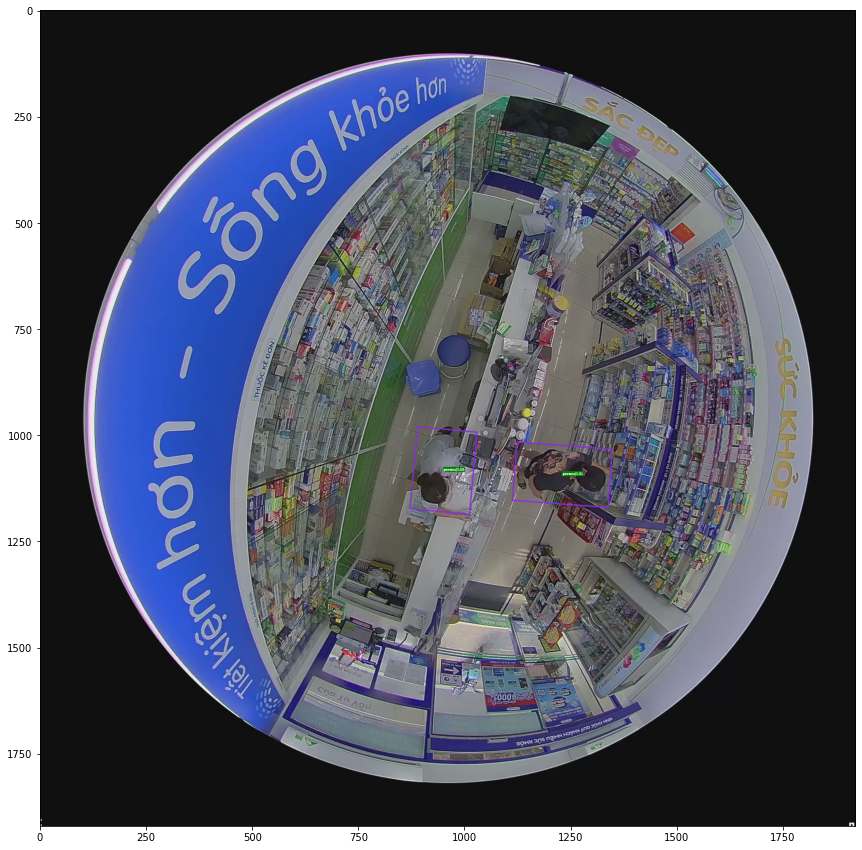

In [134]:
img = mmcv.imread('../../../data/PhamacityDota/images/lyquocsu_26210.png')
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

result = inference_detector(model, img)

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end))
model.show_result(img, result, score_thr=0.3, out_file='./output/output.png')
img = mmcv.imread('./output/output.png')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

238.94671630859375


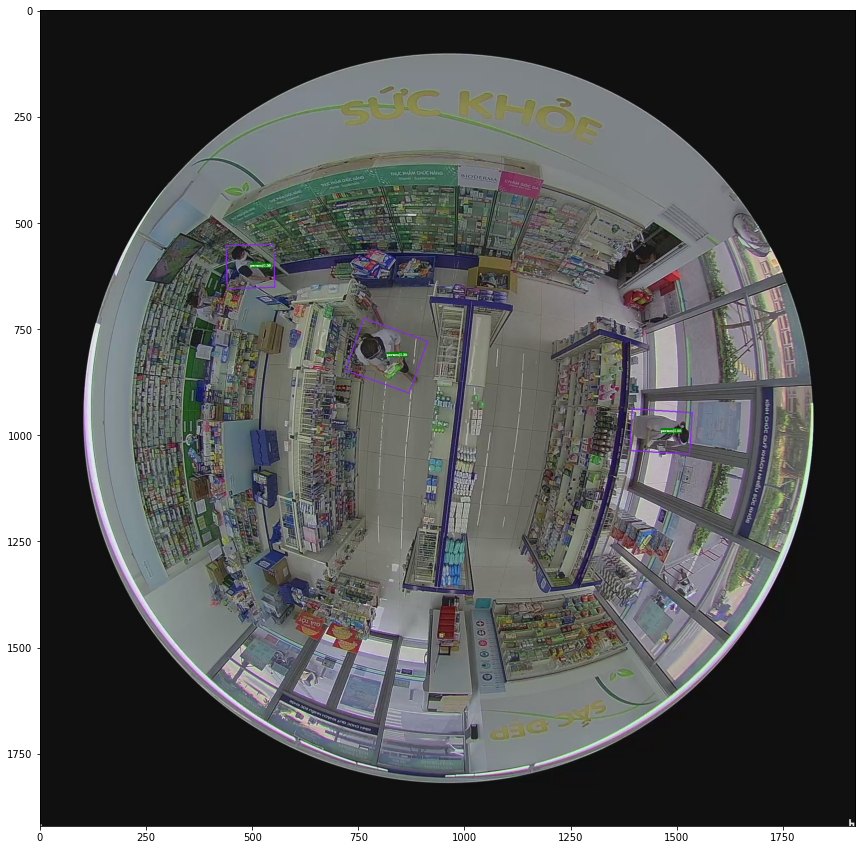

In [135]:
img = mmcv.imread('../../../data/PhamacityDota/images/timecity1_4540.png')

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

result = inference_detector(model, img)

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end))
model.show_result(img, result, score_thr=0.3, out_file='./output/output.png')
img = mmcv.imread('./output/output.png')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [108]:
def measure_inference_speed(model, path):
# the first several iterations may be very slow so skip them
    num_warmup = 5
    pure_inf_time = 0
    fps = 0
    max_iter = 100
    log_interval = 10

    # benchmark with 2000 image and take the average
    for i, filename in enumerate(os.listdir(path)):
        
        img = mmcv.imread(path + filename)
        
        torch.cuda.synchronize()
        start_time = time.perf_counter()

        result = inference_detector(model, img)

        torch.cuda.synchronize()
        elapsed = time.perf_counter() - start_time
        
        model.show_result(img, result, score_thr=0.3, out_file='./output/'+filename)

        if i >= num_warmup:
            pure_inf_time += elapsed
            if (i + 1) % log_interval == 0:
                fps = (i + 1 - num_warmup) / pure_inf_time
                print(
                    f'Done image [{i + 1:<3}/ {max_iter}], '
                    f'fps: {fps:.1f} img / s, '
                    f'times per image: {1000 / fps:.1f} ms / img',
                    flush=True)

        if (i + 1) == max_iter:
            fps = (i + 1 - num_warmup) / pure_inf_time
            print(
                f'Overall fps: {fps:.1f} img / s, '
                f'times per image: {1000 / fps:.1f} ms / img',
                flush=True)
            break
    return fps

In [126]:
measure_inference_speed(model, "../../../data/PhamacityDota/images/")

Done image [10 / 100], fps: 4.7 img / s, times per image: 211.2 ms / img
Done image [20 / 100], fps: 4.8 img / s, times per image: 210.4 ms / img
Done image [30 / 100], fps: 4.7 img / s, times per image: 211.8 ms / img
Done image [40 / 100], fps: 4.7 img / s, times per image: 210.8 ms / img
Done image [50 / 100], fps: 4.7 img / s, times per image: 210.9 ms / img
Done image [60 / 100], fps: 4.8 img / s, times per image: 210.5 ms / img
Done image [70 / 100], fps: 4.8 img / s, times per image: 210.2 ms / img
Done image [80 / 100], fps: 4.8 img / s, times per image: 210.4 ms / img
Done image [90 / 100], fps: 4.8 img / s, times per image: 210.2 ms / img
Done image [100/ 100], fps: 4.8 img / s, times per image: 209.9 ms / img
Overall fps: 4.8 img / s, times per image: 209.9 ms / img


4.764742351078634